In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential

import glob, os, random

In [16]:
base_path = 'dataset/training'

img_list = glob.glob(os.path.join(base_path, '*/*')) + glob.glob(os.path.join(base_path, '*/*/*'))

print(len(img_list))

4964


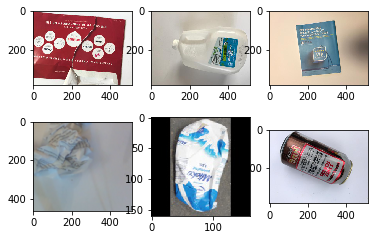

In [17]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

# flow_from_directory 폴더 형테의 데이터 구조 가지고 옴
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)



Found 4453 images belonging to 6 classes.
Found 491 images belonging to 6 classes.


In [29]:

labels = (train_generator.class_indices)

for k,v in labels.items():
    print(k)
    print(v)

labels = dict((v,k) for k,v in labels.items())

print(labels)

cardboard
0
glass
1
metal
2
paper
3
plastic
4
trash
5
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(64, activation='relu'),

    Dense(6, activation='softmax')
])
#4개의 convolution 레이어와 poolong 레이어를 가진 CNN 모델

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# 모델의 구조 파악
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 32)       

In [6]:
model.fit_generator(train_generator, steps_per_epoch=15, epochs=5, validation_data=validation_generator,validation_steps=5)

Epoch 1/5
15/15 [==============================] - 43s 3s/step - loss: 1.7112 - acc: 0.2667 - val_loss: 1.4704 - val_acc: 0.2250
Epoch 2/5
15/15 [==============================] - 35s 2s/step - loss: 1.6213 - acc: 0.2750 - val_loss: 1.6717 - val_acc: 0.3500
Epoch 3/5
15/15 [==============================] - 42s 3s/step - loss: 1.5706 - acc: 0.3500 - val_loss: 2.2302 - val_acc: 0.1875
Epoch 4/5
15/15 [==============================] - 45s 3s/step - loss: 1.6476 - acc: 0.2917 - val_loss: 1.6178 - val_acc: 0.3750
Epoch 5/5
15/15 [==============================] - 36s 2s/step - loss: 1.4511 - acc: 0.3625 - val_loss: 1.4337 - val_acc: 0.2500


In [7]:
hist = model.fit_generator(train_generator, epochs=3, validation_data=validation_generator)

Epoch 1/3
279/279 [==============================] - 677s 2s/step - loss: 1.3556 - acc: 0.4294 - val_loss: 1.0527 - val_acc: 0.4562
Epoch 2/3
279/279 [==============================] - 798s 3s/step - loss: 1.2341 - acc: 0.4655 - val_loss: 1.8332 - val_acc: 0.4908
Epoch 3/3
279/279 [==============================] - 1096s 4s/step - loss: 1.1670 - acc: 0.4947 - val_loss: 1.5074 - val_acc: 0.5316


In [8]:
print("-- Evaluate --")
scores = model.evaluate_generator(validation_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
acc: 46.25%


In [9]:
# 모델 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

# 모델 weight 저장
keras_file="garbage.h5"
model.save(keras_file)

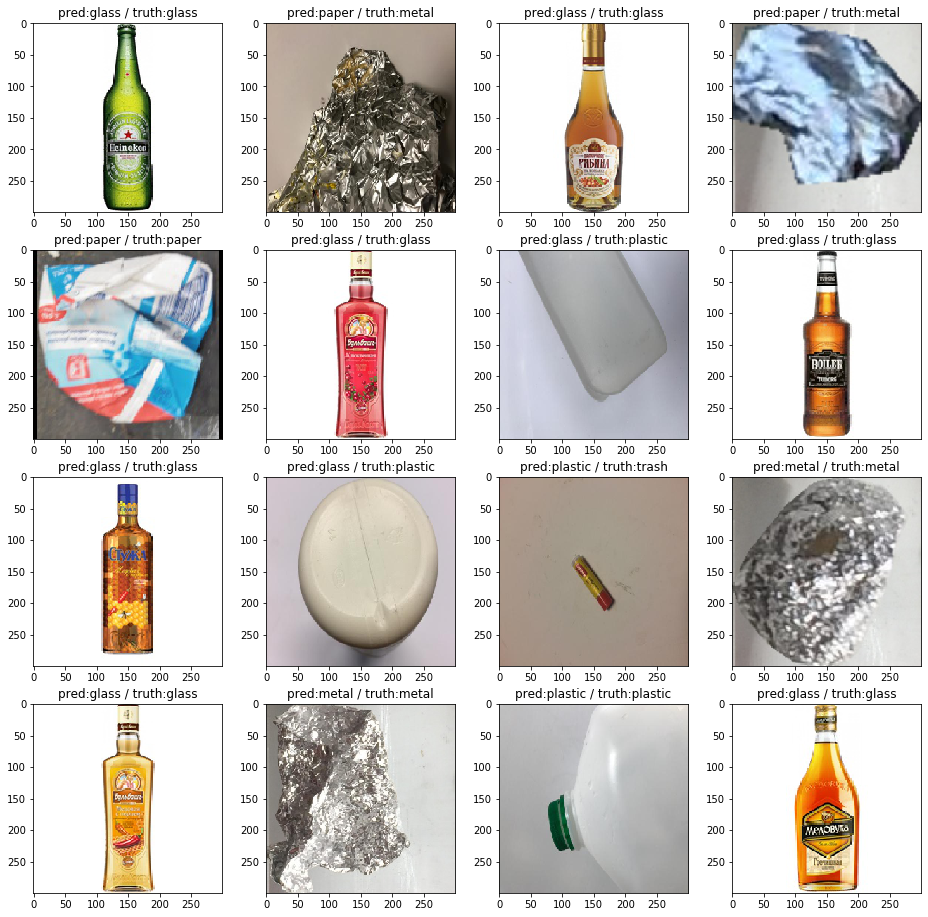

In [10]:
test_x, test_y = validation_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

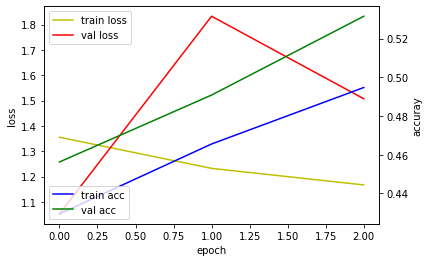

In [11]:
# 모델 학습 그래프 확인
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()